# Get data

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DATA_PATH= os.path.join('data')

files= os.listdir(DATA_PATH)
data= pd.DataFrame()

for file in files:
    file_path= os.path.join(DATA_PATH, file)
    season= file.split('.')[0]
    df= pd.read_csv(file_path)
    df['Season']= season
    data= pd.concat([data, df], ignore_index=True)

# Clean data

I will not use the odds for the model for the following reasons :

- Some bookmaker statistics are in one file but not in another
- If the logic used by the betting site changes from one year to another, then we would create biases

We may use a model with the odds if we have time or just in order to compare with the results

In [2]:
with open('notes.txt', 'r', encoding='utf-8') as f:
    content = f.read()
    sections= content.split('\n\n')

In [3]:
def get_columns_from_section(section):
    col_names= []
    lines= sections[section].split('\n')
    for elt in lines:
        if '=' in elt:
            parts= elt.split('and')
            for part in parts:
                col_name= part.split('=')[0].strip()
                col_names.append(col_name)
    return col_names

cols_third_section= get_columns_from_section(3)
cols_fourth_section= get_columns_from_section(4)
cols_to_keep= ['Season'] + cols_third_section + cols_fourth_section

In [4]:
existing_cols = [c for c in cols_to_keep if c in data.columns]
final_data= data[existing_cols]

In [5]:
final_data.isna().sum()

Season        0
Div           0
Date          0
Time        380
HomeTeam      0
AwayTeam      0
FTHG          0
FTAG          0
FTR           0
HTHG          0
HTAG          0
HTR           0
Referee       0
HS            0
AS            0
HST           0
AST           0
HC            0
AC            0
HF            0
AF            0
HY            0
AY            0
HR            0
AR            0
dtype: int64

In [6]:
final_data[final_data['Time'].isna()]['Season'].unique()

array(['2018-2019'], dtype=object)

# Feature engineering

I think "Time" would be interesting to keep for the modeling part, so I will delete season 2018-2019. 4 seasons should be sufficient for the training.

Let us now do rolling windows in order to compute data before match

In [7]:
final_data['Date'] = pd.to_datetime(final_data['Date'], dayfirst=True, errors='coerce')
final_data_sorted = final_data.sort_values(['Season', 'Date']).reset_index(drop=True)
final_data_sorted['match_id'] = final_data_sorted.index

home_long = final_data_sorted[['match_id', 'Season', 'Date', 'HomeTeam']].rename(columns={'HomeTeam':'Team'})
away_long = final_data_sorted[['match_id', 'Season', 'Date', 'AwayTeam']].rename(columns={'AwayTeam':'Team'})
long = pd.concat([home_long.assign(is_home=1), away_long.assign(is_home=0)], ignore_index=True)
long = long.sort_values(['Team', 'Season', 'Date'])

long['prev_date'] = long.groupby(['Team', 'Season'])['Date'].shift(1)
long['days_rest'] = (long['Date'] - long['prev_date']).dt.days.fillna(0).astype(int)

home_rest = long[long['is_home']==1][['match_id','days_rest']].rename(columns={'days_rest':'home_days_rest'})
away_rest = long[long['is_home']==0][['match_id','days_rest']].rename(columns={'days_rest':'away_days_rest'})

final = final_data_sorted.merge(home_rest, on='match_id', how='left').merge(away_rest, on='match_id', how='left')
final['home_days_rest'] = final['home_days_rest'].fillna(0).astype(int)
final['away_days_rest'] = final['away_days_rest'].fillna(0).astype(int)


C:\Users\vgvic\AppData\Local\Temp\ipykernel_11700\2115981385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Date'] = pd.to_datetime(final_data['Date'], dayfirst=True, errors='coerce')


In [8]:
def create_features_before_match_enriched(data, recent_matches=5):
    features = data.copy()
    
    # Features de base
    base_cols = [
        'home_avg_goals','home_avg_conceded','away_avg_goals','away_avg_conceded',
        'home_recent_form','away_recent_form',
        'home_h2h_wins','away_h2h_wins',
        'home_home_record','away_away_record',
        'goal_diff_avg','conceded_diff_avg','form_diff'
    ]
    for col in base_cols:
        features[col] = np.nan

    def points_for_team(hist_row, team_name):
        if hist_row['HomeTeam'] == team_name:
            if hist_row['FTR'] == 'H': return 3
            if hist_row['FTR'] == 'D': return 1
            return 0
        else:
            if hist_row['FTR'] == 'A': return 3
            if hist_row['FTR'] == 'D': return 1
            return 0

    for idx, row in features.iterrows():
        if idx == 0: continue
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        history_window = features.iloc[:idx]

        # ===== Moyennes glissantes =====
        def compute_team_stats(team_name):
            matches = history_window[(history_window['HomeTeam']==team_name)|(history_window['AwayTeam']==team_name)]
            goals_scored = matches.loc[matches['HomeTeam']==team_name,'FTHG'].sum() + matches.loc[matches['AwayTeam']==team_name,'FTAG'].sum()
            goals_conceded = matches.loc[matches['HomeTeam']==team_name,'FTAG'].sum() + matches.loc[matches['AwayTeam']==team_name,'FTHG'].sum()
            return (goals_scored/len(matches) if len(matches)>0 else 0,
                    goals_conceded/len(matches) if len(matches)>0 else 0,
                    matches)
        
        home_avg_goals, home_avg_conceded, home_matches = compute_team_stats(home_team)
        away_avg_goals, away_avg_conceded, away_matches = compute_team_stats(away_team)

        features.at[idx,'home_avg_goals'] = home_avg_goals
        features.at[idx,'home_avg_conceded'] = home_avg_conceded
        features.at[idx,'away_avg_goals'] = away_avg_goals
        features.at[idx,'away_avg_conceded'] = away_avg_conceded

        # ===== Forme récente pondérée =====
        def recent_points(matches, team_name):
            last = matches.tail(recent_matches)
            weights = np.arange(len(last),0,-1)
            points = last.apply(lambda r: points_for_team(r, team_name), axis=1)
            return np.sum(points * weights)
        
        features.at[idx,'home_recent_form'] = recent_points(home_matches, home_team)
        features.at[idx,'away_recent_form'] = recent_points(away_matches, away_team)

        # ===== H2H complet =====
        h2h = history_window[
            ((history_window['HomeTeam']==home_team) & (history_window['AwayTeam']==away_team)) |
            ((history_window['HomeTeam']==away_team) & (history_window['AwayTeam']==home_team))
        ]
        home_h2h_wins = len(h2h[((h2h['HomeTeam']==home_team)&(h2h['FTR']=='H')) | ((h2h['AwayTeam']==home_team)&(h2h['FTR']=='A'))])
        away_h2h_wins = len(h2h[((h2h['HomeTeam']==away_team)&(h2h['FTR']=='H')) | ((h2h['AwayTeam']==away_team)&(h2h['FTR']=='A'))])
        features.at[idx,'home_h2h_wins'] = home_h2h_wins
        features.at[idx,'away_h2h_wins'] = away_h2h_wins

        # ===== Record domicile/extérieur =====
        home_at_home = history_window[history_window['HomeTeam']==home_team]
        away_at_away = history_window[history_window['AwayTeam']==away_team]
        features.at[idx,'home_home_record'] = len(home_at_home[home_at_home['FTR']=='H'])/len(home_at_home) if len(home_at_home)>0 else 0
        features.at[idx,'away_away_record'] = len(away_at_away[away_at_away['FTR']=='A'])/len(away_at_away) if len(away_at_away)>0 else 0

        # ===== Différences synthétiques =====
        features.at[idx,'goal_diff_avg'] = home_avg_goals - away_avg_goals
        features.at[idx,'conceded_diff_avg'] = home_avg_conceded - away_avg_conceded
        features.at[idx,'form_diff'] = features.at[idx,'home_recent_form'] - features.at[idx,'away_recent_form']

    return features


In [9]:
features_df = create_features_before_match_enriched(final, recent_matches=5)

We may have issues if the first row data has some NaN + I want to have the Time feature.

In [10]:
features_df= features_df[features_df['Season'] != '2018-2019']

features_df['Time'] = features_df['Time'].astype(str).str.strip()
# features_df['Hour'] = features_df['Time'].str[:2].astype(int)
features_df= features_df.drop(columns= ['Time'])
ftr_mapping = {'H': 0, 'D': 1, 'A': 2}
features_df['FTR'] = features_df['FTR'].map(ftr_mapping)

We briefly checked and everything looks correct. Still between seasons we may have limits

We tried to compute an alo as per a ranking system, but it did not seem to be useful for the models

In [11]:
# def compute_elo(data, K=30, home_advantage=100, initial_elo=1500):
#     """
#     Ajoute des colonnes Elo dans le dataframe :
#     - elo_home
#     - elo_away
#     - elo_diff = elo_home - elo_away
#     """

#     # Elo initial pour chaque équipe
#     teams = pd.unique(data[['HomeTeam', 'AwayTeam']].values.ravel())
#     elo = {team: initial_elo for team in teams}

#     # Colonnes à remplir
#     data['elo_home'] = np.nan
#     data['elo_away'] = np.nan

#     for idx, row in data.iterrows():

#         home = row['HomeTeam']
#         away = row['AwayTeam']

#         # Récupération Elo avant match
#         elo_home = elo[home]
#         elo_away = elo[away]

#         # Stockage dans le dataset
#         data.at[idx, 'elo_home'] = elo_home
#         data.at[idx, 'elo_away'] = elo_away

#         # Calcul du score attendu (expected outcome)
#         expected_home = 1 / (1 + 10 ** ((elo_away - (elo_home + home_advantage)) / 400))
#         expected_away = 1 - expected_home

#         # Score réel (H=1, D=0.5, A=0)
#         if row['FTR'] == 'H':
#             score_home = 1
#             score_away = 0
#         elif row['FTR'] == 'A':
#             score_home = 0
#             score_away = 1
#         else:  # 'D'
#             score_home = 0.5
#             score_away = 0.5

#         # Mise à jour Elo
#         elo[home] += K * (score_home - expected_home)
#         elo[away] += K * (score_away - expected_away)

#     # Différentiel Elo (bon feature pour les modèles)
#     data['elo_diff'] = data['elo_home'] - data['elo_away']

#     return data

# features_df = compute_elo(features_df, K=100, home_advantage=100, initial_elo=1500)


# Looking for better parameters

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

K_values = [20, 50, 100, 150]
home_adv_values = [0, 50, 100, 150]
n_estimators_list = [100, 200]
max_depth_list = [6, 8, 12]
min_samples_leaf_list = [3, 5]

results = []

train_seasons = ['2019-2020', '2020-2021', '2021-2022', '2022-2023']
val_seasons = ['2023-2024']
test_seasons = ['2024-2025']

cols_to_delete= ['HomeTeam', 'AwayTeam', 'match_id', 'Div', 'Date', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']

# ------------------------------
# BOUCLE DE RECHERCHE
# ------------------------------
for K in K_values:
    for home_adv in home_adv_values:
        # Recalcul Elo
        # tmp_df = compute_elo(features_df.copy(), K=K, home_advantage=home_adv)

        # Nettoyage
        tmp_df = features_df.copy().drop(columns=cols_to_delete)
        # tmp_df = tmp_df.drop(columns=cols_to_delete)

        # Split saisonnier
        X_train = tmp_df[tmp_df["Season"].isin(train_seasons)].drop(columns=["FTR", "Season"])
        y_train = tmp_df[tmp_df["Season"].isin(train_seasons)]["FTR"]

        X_val = tmp_df[tmp_df["Season"].isin(val_seasons)].drop(columns=["FTR", "Season"])
        y_val = tmp_df[tmp_df["Season"].isin(val_seasons)]["FTR"]

        X_test = tmp_df[tmp_df["Season"].isin(test_seasons)].drop(columns=["FTR", "Season"])
        y_test = tmp_df[tmp_df["Season"].isin(test_seasons)]["FTR"]

        for n in n_estimators_list:
            for depth in max_depth_list:
                for leaf in min_samples_leaf_list:

                    model = RandomForestClassifier(
                        n_estimators=n,
                        max_depth=depth,
                        min_samples_leaf=leaf,
                        random_state=42
                    )

                    model.fit(X_train, y_train)

                    val_pred = model.predict(X_val)
                    test_pred = model.predict(X_test)

                    val_acc = accuracy_score(y_val, val_pred)
                    test_acc = accuracy_score(y_test, test_pred)

                    results.append({
                        "K": K,
                        "home_adv": home_adv,
                        "n_estimators": n,
                        "max_depth": depth,
                        "min_samples_leaf": leaf,
                        "val_acc": val_acc,
                        "test_acc": test_acc
                    })

                    print(
                        f"K={K}, HA={home_adv} | n={n}, depth={depth}, leaf={leaf} "
                        f"=> Val={val_acc:.4f}, Test={test_acc:.4f}"
                    )

# Convertir en DataFrame pour analyser les meilleurs résultats
results_df = pd.DataFrame(results)

print("\n🔝 Meilleurs modèles triés par validation accuracy :")
print(results_df.sort_values(by="val_acc", ascending=False).head(10))


K=20, HA=0 | n=100, depth=6, leaf=3 => Val=0.5737, Test=0.4974
K=20, HA=0 | n=100, depth=6, leaf=5 => Val=0.5684, Test=0.4921
K=20, HA=0 | n=100, depth=8, leaf=3 => Val=0.5711, Test=0.4684
K=20, HA=0 | n=100, depth=8, leaf=5 => Val=0.5658, Test=0.4974
K=20, HA=0 | n=100, depth=12, leaf=3 => Val=0.5474, Test=0.4789
K=20, HA=0 | n=100, depth=12, leaf=5 => Val=0.5658, Test=0.4921
K=20, HA=0 | n=200, depth=6, leaf=3 => Val=0.5605, Test=0.4921
K=20, HA=0 | n=200, depth=6, leaf=5 => Val=0.5711, Test=0.4947
K=20, HA=0 | n=200, depth=8, leaf=3 => Val=0.5711, Test=0.4789
K=20, HA=0 | n=200, depth=8, leaf=5 => Val=0.5605, Test=0.5026
K=20, HA=0 | n=200, depth=12, leaf=3 => Val=0.5658, Test=0.4842
K=20, HA=0 | n=200, depth=12, leaf=5 => Val=0.5658, Test=0.4816
K=20, HA=50 | n=100, depth=6, leaf=3 => Val=0.5737, Test=0.4974
K=20, HA=50 | n=100, depth=6, leaf=5 => Val=0.5684, Test=0.4921
K=20, HA=50 | n=100, depth=8, leaf=3 => Val=0.5711, Test=0.4684
K=20, HA=50 | n=100, depth=8, leaf=5 => Val=0.56

Il faut maintenant que je sépare toutes les features des targets. Il faut aussi que je convertisse les données telles que le temps

# Creating models

In [13]:
results_df = pd.DataFrame(results)
best_params = results_df.sort_values(by="val_acc", ascending=False).iloc[0]

print("\n🎯 Meilleurs paramètres trouvés :")
print(best_params)

# ------------------------------
# MODÈLE FINAL AVEC LES MEILLEURS PARAMÈTRES
# ------------------------------
best_K = int(best_params["K"])
best_home_adv = int(best_params["home_adv"])
best_n = int(best_params["n_estimators"])
best_depth = int(best_params["max_depth"])
best_leaf = int(best_params["min_samples_leaf"])

# Recalcul du Elo final
# final_df = compute_elo(features_df.copy(), K=best_K, home_advantage=best_home_adv)
final_df = features_df.copy().drop(columns=cols_to_delete)

# Ré-entraînement avec les BEST params
X_train = final_df[final_df["Season"].isin(train_seasons)].drop(columns=["FTR", "Season"])
y_train = final_df[final_df["Season"].isin(train_seasons)]["FTR"]

X_val = final_df[final_df["Season"].isin(val_seasons)].drop(columns=["FTR", "Season"])
y_val = final_df[final_df["Season"].isin(val_seasons)]["FTR"]

X_test = final_df[final_df["Season"].isin(test_seasons)].drop(columns=["FTR", "Season"])
y_test = final_df[final_df["Season"].isin(test_seasons)]["FTR"]

# Modèle final
final_model = RandomForestClassifier(
    n_estimators=best_n,
    max_depth=best_depth,
    min_samples_leaf=best_leaf,
    random_state=42
)
final_model.fit(X_train, y_train)

# Scores finaux
val_pred = final_model.predict(X_val)
test_pred = final_model.predict(X_test)

print("\n🏆 SCORE FINAL")
print("Validation accuracy :", accuracy_score(y_val, val_pred))
print("Test accuracy :", accuracy_score(y_test, test_pred))


🎯 Meilleurs paramètres trouvés :
K                    20.000000
home_adv              0.000000
n_estimators        100.000000
max_depth             6.000000
min_samples_leaf      3.000000
val_acc               0.573684
test_acc              0.497368
Name: 0, dtype: float64

🏆 SCORE FINAL
Validation accuracy : 0.5736842105263158
Test accuracy : 0.49736842105263157



📊 Feature Importances :
goal_diff_avg        0.151847
conceded_diff_avg    0.143769
home_avg_goals       0.093535
home_home_record     0.086820
away_avg_goals       0.083291
home_avg_conceded    0.075766
away_away_record     0.066890
away_avg_conceded    0.065932
form_diff            0.064078
home_recent_form     0.038474
away_recent_form     0.036685
away_days_rest       0.028817
home_days_rest       0.024648
home_h2h_wins        0.020111
away_h2h_wins        0.019336
dtype: float64


C:\Users\vgvic\AppData\Local\Temp\ipykernel_11700\1657652140.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances.values, y=feat_importances.index, palette="viridis")


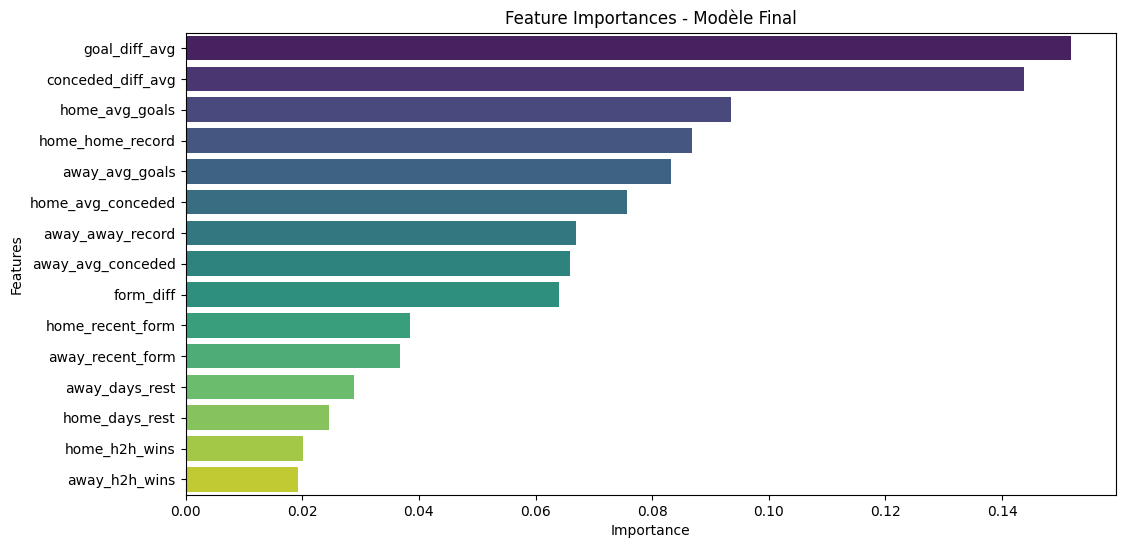

In [14]:
# Feature importances
feat_importances = pd.Series(final_model.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)

print("\n📊 Feature Importances :")
print(feat_importances)

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(x=feat_importances.values, y=feat_importances.index, palette="viridis")
plt.title("Feature Importances - Modèle Final")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, test_pred)

array([[122,   0,  33],
       [ 59,   0,  34],
       [ 65,   0,  67]])

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)
lr_val_pred = lr_model.predict(X_val)
lr_test_pred = lr_model.predict(X_test)
print("Logistic Regression - Validation accuracy:", accuracy_score(y_val, lr_val_pred))
print("Logistic Regression - Test accuracy:", accuracy_score(y_test, lr_test_pred))

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_val_pred = gb_model.predict(X_val)
gb_test_pred = gb_model.predict(X_test)
print("Gradient Boosting - Validation accuracy:", accuracy_score(y_val, gb_val_pred))
print("Gradient Boosting - Test accuracy:", accuracy_score(y_test, gb_test_pred))

# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_val_pred = knn_model.predict(X_val)
knn_test_pred = knn_model.predict(X_test)
print("KNN - Validation accuracy:", accuracy_score(y_val, knn_val_pred))
print("KNN - Test accuracy:", accuracy_score(y_test, knn_test_pred))


Logistic Regression - Validation accuracy: 0.5157894736842106
Logistic Regression - Test accuracy: 0.43157894736842106
Gradient Boosting - Validation accuracy: 0.5342105263157895
Gradient Boosting - Test accuracy: 0.4421052631578947
KNN - Validation accuracy: 0.45263157894736844
KNN - Test accuracy: 0.38421052631578945


In [17]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Créer le modèle XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Entraînement
xgb_model.fit(X_train, y_train)

# Validation
xgb_val_pred = xgb_model.predict(X_val)
print("XGBoost - Validation accuracy:", accuracy_score(y_val, xgb_val_pred))

# Test
xgb_test_pred = xgb_model.predict(X_test)
print("XGBoost - Test accuracy:", accuracy_score(y_test, xgb_test_pred))

c:\Users\vgvic\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:29:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Validation accuracy: 0.5421052631578948
XGBoost - Test accuracy: 0.4710526315789474


We could add more seasons, otherwise see which features have the most impact and then do some feature engineering for the models